# Importing Libraries

In [29]:
!pip install tqdm

In [30]:
import argparse
import random
import os
from pathlib import Path
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

# Dataset Generation

In [31]:
def set_seed(seed: int = 42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


class ReverseDataset(Dataset):
    def __init__(self, data, pad_idx=0):
        self.data = data
        self.pad_idx = pad_idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src, trg = self.data[idx]
        return torch.tensor(src, dtype=torch.long), torch.tensor(trg, dtype=torch.long)

    @staticmethod
    def collate_fn(batch):
        src_batch, trg_batch = zip(*batch)
        lengths = [len(s) for s in src_batch]
        max_len = max(lengths)
        src_padded = [torch.cat([s, torch.zeros(max_len - len(s), dtype=torch.long)]) for s in src_batch]
        trg_padded = [torch.cat([t, torch.zeros(max_len - len(t), dtype=torch.long)]) for t in trg_batch]
        return torch.stack(src_padded), torch.stack(trg_padded), torch.tensor(lengths, dtype=torch.long)

# Model Architecture

In [32]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1, dropout=0.1, bidirectional=True):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(
            embed_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        self.num_layers = num_layers
        self.num_directions = 2 if bidirectional else 1
        self.hidden_size = hidden_size

    def forward(self, src, lengths):
        embedded = self.embedding(src)
        packed = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        outputs, hidden = self.gru(packed)
        outputs, _ = pad_packed_sequence(outputs, batch_first=True)
        if self.num_directions == 2:
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)
            hidden = torch.cat([hidden[:, 0], hidden[:, 1]], dim=2)
        return outputs, hidden


class Attention(nn.Module):
    def __init__(self, enc_hidden_size, dec_hidden_size):
        super().__init__()
        self.attn = nn.Linear(enc_hidden_size + dec_hidden_size, dec_hidden_size)
        self.v = nn.Parameter(torch.rand(dec_hidden_size))

    def forward(self, hidden, encoder_outputs, mask=None):
        seq_len = encoder_outputs.size(1)
        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        energy = energy.permute(0, 2, 1)
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)
        weights = torch.bmm(v, energy).squeeze(1)
        if mask is not None:
            weights = weights.masked_fill(mask == 0, -1e9)
        return torch.softmax(weights, dim=1)


class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, enc_hidden_size, dec_hidden_size, attention, num_layers=1, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.attention = attention
        self.gru = nn.GRU(
            embed_size + enc_hidden_size,
            dec_hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(dec_hidden_size + enc_hidden_size, vocab_size)

    def forward(self, input_step, hidden, encoder_outputs, mask=None):
        embedded = self.embedding(input_step).unsqueeze(1)
        dec_hidden = hidden[-1]
        attn_weights = self.attention(dec_hidden, encoder_outputs, mask)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        rnn_input = torch.cat((embedded, context), dim=2)
        output, hidden = self.gru(rnn_input, hidden)
        output = output.squeeze(1)
        context = context.squeeze(1)
        output = self.fc(torch.cat((output, context), dim=1))
        return output, hidden, attn_weights


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        enc_dim = encoder.hidden_size * encoder.num_directions
        dec_dim = decoder.gru.hidden_size
        self.bridge = nn.Linear(enc_dim, dec_dim)

    def create_mask(self, lengths, max_len):
        batch_size = lengths.size(0)
        mask = torch.arange(max_len).expand(batch_size, max_len).to(self.device)
        return (mask < lengths.unsqueeze(1)).long()

    def forward(self, src, trg, lengths, teacher_forcing_ratio=0.5):
        batch_size, trg_len = trg.size()
        vocab_size = self.decoder.embedding.num_embeddings
        outputs = torch.zeros(batch_size, trg_len, vocab_size).to(self.device)

        encoder_outputs, hidden = self.encoder(src, lengths)
        hidden = torch.tanh(self.bridge(hidden.permute(1, 0, 2)))
        hidden = hidden.permute(1, 0, 2).contiguous()

        input_step = trg[:, 0]
        mask = self.create_mask(lengths, encoder_outputs.size(1))

        for t in range(1, trg_len):
            output, hidden, _ = self.decoder(input_step, hidden, encoder_outputs, mask)
            outputs[:, t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input_step = trg[:, t] if teacher_force else top1
        return outputs

# Traning & Evaluating

In [33]:

def train_epoch(model, dataloader, optimizer, criterion, clip):
    model.train()
    epoch_loss, epoch_correct, epoch_total = 0, 0, 0
    for src, trg, lengths in tqdm(dataloader, desc="Training", leave=False):
        src, trg, lengths = src.to(model.device), trg.to(model.device), lengths.to(model.device)
        optimizer.zero_grad()
        output = model(src, trg, lengths)
        output_dim = output.shape[-1]
        out = output[:, 1:].reshape(-1, output_dim)
        trg_flat = trg[:, 1:].reshape(-1)
        loss = criterion(out, trg_flat)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()
        preds = out.argmax(1)
        mask = trg_flat != dataloader.dataset.pad_idx
        epoch_correct += (preds[mask] == trg_flat[mask]).sum().item()
        epoch_total += mask.sum().item()

    return epoch_loss / len(dataloader), epoch_correct / epoch_total


def evaluate_epoch(model, dataloader, criterion):
    model.eval()
    epoch_loss, epoch_correct, epoch_total = 0, 0, 0
    with torch.no_grad():
        for src, trg, lengths in tqdm(dataloader, desc="Evaluating", leave=False):
            src, trg, lengths = src.to(model.device), trg.to(model.device), lengths.to(model.device)
            output = model(src, trg, lengths, teacher_forcing_ratio=0)
            output_dim = output.shape[-1]
            out = output[:, 1:].reshape(-1, output_dim)
            trg_flat = trg[:, 1:].reshape(-1)
            loss = criterion(out, trg_flat)
            epoch_loss += loss.item()
            preds = out.argmax(1)
            mask = trg_flat != dataloader.dataset.pad_idx
            epoch_correct += (preds[mask] == trg_flat[mask]).sum().item()
            epoch_total += mask.sum().item()

    return epoch_loss / len(dataloader), epoch_correct / epoch_total

# Main Runner

In [34]:
def main(args):
    set_seed(args.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    data = [([random.randint(1, args.vocab_size-1) for _ in range(args.seq_len)], None)
            for _ in range(args.num_samples)]
    data = [(src, list(reversed(src))) for src, _ in data]
    split = int(len(data) * args.train_split)
    train_data, val_data = data[:split], data[split:]

    train_ds = ReverseDataset(train_data)
    val_ds = ReverseDataset(val_data)
    train_loader = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True,
                              collate_fn=ReverseDataset.collate_fn)
    val_loader = DataLoader(val_ds, batch_size=args.batch_size, shuffle=False,
                            collate_fn=ReverseDataset.collate_fn)

    enc = Encoder(args.vocab_size, args.embed_size, args.hidden_size,
                  args.enc_layers, args.dropout, bidirectional=True)
    attn = Attention(enc.hidden_size * enc.num_directions, args.hidden_size)
    dec = Decoder(args.vocab_size, args.embed_size,
                  enc.hidden_size * enc.num_directions, args.hidden_size,
                  attn, args.dec_layers, args.dropout)
    model = Seq2Seq(enc, dec, device).to(device)

    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    criterion = nn.CrossEntropyLoss(ignore_index=0)

    writer = SummaryWriter(log_dir=args.log_dir)
    best_val_loss = float('inf')
    ckpt_dir = Path(args.checkpoint_dir)
    ckpt_dir.mkdir(parents=True, exist_ok=True)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(1, args.epochs + 1):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, args.clip)
        val_loss, val_acc = evaluate_epoch(model, val_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        writer.add_scalars('Loss', {'train': train_loss, 'val': val_loss}, epoch)
        writer.add_scalars('Accuracy', {'train': train_acc, 'val': val_acc}, epoch)

        print(f"Epoch {epoch:02d} | Train Loss: {train_loss*100:.2f}%, Acc: {train_acc*100:.2f}% | "
              f"Val Loss: {val_loss*100:.2f}%, Acc: {val_acc*100:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), ckpt_dir / 'best_model.pt')

    writer.close()

    # Plot Loss
    plt.figure()
    plt.plot(range(1, args.epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, args.epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure()
    plt.plot(range(1, args.epochs + 1), train_accs, label='Train Acc')
    plt.plot(range(1, args.epochs + 1), val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()
    plt.show()

# Calling the Main Function

Epoch 01 | Train Loss: 316.30%, Acc: 16.73% | Val Loss: 196.13%, Acc: 40.92%


Epoch 02 | Train Loss: 102.51%, Acc: 71.17% | Val Loss: 39.23%, Acc: 90.02%


Epoch 03 | Train Loss: 27.11%, Acc: 94.29% | Val Loss: 8.04%, Acc: 98.89%


Epoch 04 | Train Loss: 10.02%, Acc: 98.02% | Val Loss: 2.79%, Acc: 99.59%


Epoch 05 | Train Loss: 3.24%, Acc: 99.50% | Val Loss: 3.75%, Acc: 99.14%


Epoch 06 | Train Loss: 3.56%, Acc: 99.31% | Val Loss: 0.80%, Acc: 99.91%


Epoch 07 | Train Loss: 1.58%, Acc: 99.75% | Val Loss: 0.47%, Acc: 99.96%


Epoch 08 | Train Loss: 2.07%, Acc: 99.60% | Val Loss: 2.04%, Acc: 99.68%


Epoch 09 | Train Loss: 2.33%, Acc: 99.56% | Val Loss: 0.22%, Acc: 99.99%


Epoch 10 | Train Loss: 0.68%, Acc: 99.89% | Val Loss: 0.18%, Acc: 99.99%


Epoch 11 | Train Loss: 1.61%, Acc: 99.69% | Val Loss: 0.21%, Acc: 100.00%


Epoch 12 | Train Loss: 0.54%, Acc: 99.92% | Val Loss: 0.31%, Acc: 99.96%


Epoch 13 | Train Loss: 0.42%, Acc: 99.94% | Val Loss: 0.09%, Acc: 100.00%


Epoch 14 | Train Loss: 1.10%, Acc: 99.79% | Val Loss: 0.15%, Acc: 100.00%


Epoch 15 | Train Loss: 0.75%, Acc: 99.88% | Val Loss: 0.30%, Acc: 99.93%


Epoch 16 | Train Loss: 0.44%, Acc: 99.93% | Val Loss: 0.08%, Acc: 100.00%


Epoch 17 | Train Loss: 0.25%, Acc: 99.95% | Val Loss: 0.08%, Acc: 99.99%


Epoch 18 | Train Loss: 0.50%, Acc: 99.91% | Val Loss: 0.14%, Acc: 99.99%


Epoch 19 | Train Loss: 0.83%, Acc: 99.86% | Val Loss: 0.18%, Acc: 99.97%


Epoch 20 | Train Loss: 0.72%, Acc: 99.87% | Val Loss: 0.07%, Acc: 100.00%


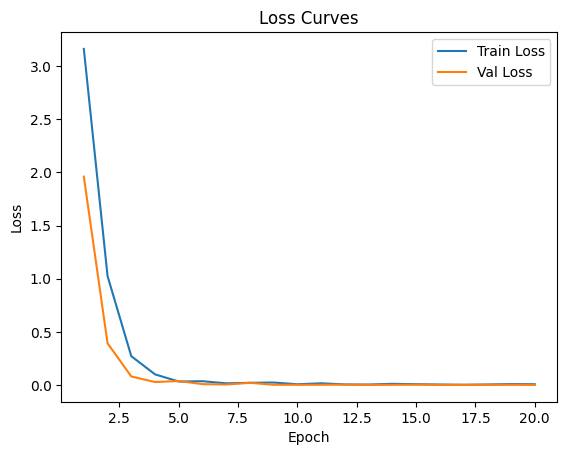

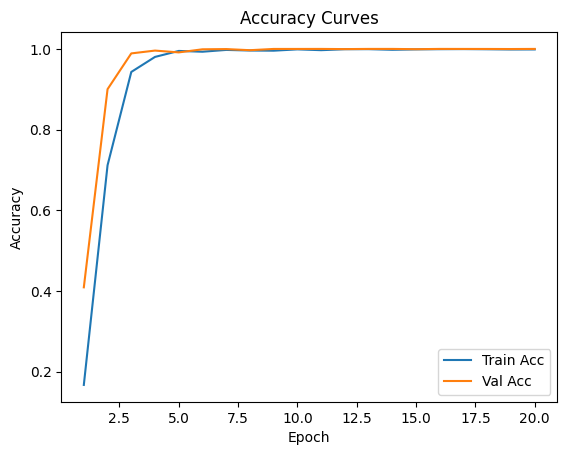

In [35]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Seq2Seq with Attention', add_help=False)
    parser.add_argument('--num_samples', type=int, default=10000)
    parser.add_argument('--seq_len', type=int, default=10)
    parser.add_argument('--vocab_size', type=int, default=50)
    parser.add_argument('--embed_size', type=int, default=64)
    parser.add_argument('--hidden_size', type=int, default=128)
    parser.add_argument('--enc_layers', type=int, default=2)
    parser.add_argument('--dec_layers', type=int, default=2)
    parser.add_argument('--dropout', type=float, default=0.2)
    parser.add_argument('--batch_size', type=int, default=128)
    parser.add_argument('--epochs', type=int, default=20)
    parser.add_argument('--lr', type=float, default=1e-3)
    parser.add_argument('--clip', type=float, default=1.0)
    parser.add_argument('--train_split', type=float, default=0.8)
    parser.add_argument('--seed', type=int, default=42)
    parser.add_argument('--log_dir', type=str, default='runs')
    parser.add_argument('--checkpoint_dir', type=str, default='checkpoints')
    args, _ = parser.parse_known_args()
    main(args)